Hey guys, this kernel is a very simple baseline for the competition and I train the images using Keras VGG16. 

I'll keep making changes to the kernel as I'm trying to improve the model. If you like the kernel, **Don't forget to upvote**.

## About the competition

With more than 1 million new diagnoses reported every year, prostate cancer (PCa) is the second most common cancer among males worldwide that results in more than 350,000 deaths annually. The key to decreasing mortality is developing more precise diagnostics. Diagnosis of PCa is based on the grading of prostate tissue biopsies. These tissue samples are examined by a pathologist and scored according to the Gleason grading system. In this challenge, we have to develop models for detecting PCa on images of prostate tissue samples.

The training set consists of around 11,000 whole-slide(WSI) images of digitized H&E-stained biopsies(a standard way of staining the originally transparent tissue to produce some contrast) originating from Radboud University Medical Center and Karolinska Institute(the data_provider field in train/test corresponds to this).

The data is provided in 4 parts:-
* train.csv:- That contains the image_id,name of either of the two data provider, gleason and ISUP grade.
* test.csv:- containing just image_ids and data_provider.
* train_images:- A folder containing biopsy images in a large multilevel .tiff file.(some of these images will be used for testing).
* tarin_label_masks:-A folder containing segmentation masks showing which parts of the image led to the ISUP grade. Not all training images have label masks, and there may be false positives or false negatives in the label masks for a variety of reasons. These masks are provided to assist with the development of strategies for selecting the most useful subsamples of the images. The mask values also depend on the data provider.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import openslide
import os
import cv2
import PIL
from IPython.display import Image, display
from keras.applications.vgg16 import VGG16,preprocess_input
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import skimage.io
from sklearn.model_selection import KFold
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import tensorflow as tf
from tensorflow.python.keras import backend as K
sess = K.get_session()

Using TensorFlow backend.


In [2]:
train=pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv')
train.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0



Let's take a look at one of the biopsy.

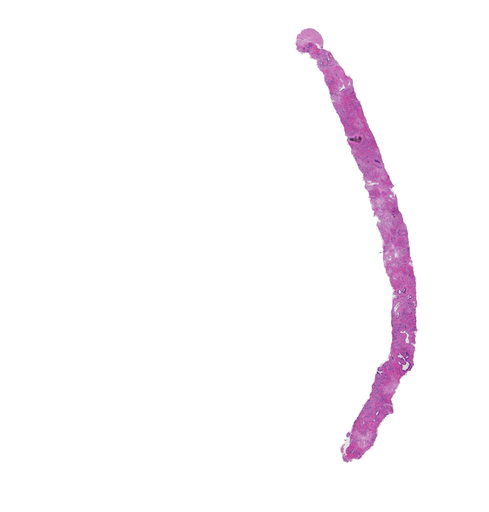

In [3]:
img=openslide.OpenSlide('/kaggle/input/prostate-cancer-grade-assessment/train_images/2fd1c7dc4a0f3a546a59717d8e9d28c3.tiff')
display(img.get_thumbnail(size=(512,512)))

In [4]:
img.dimensions

(27648, 28928)

These images are pretty big in size for training I'll be using the resized 512x512 dataset uploaded by @xhlulu.

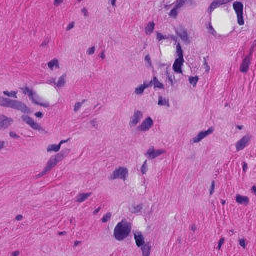

In [5]:
patch = img.read_region((18500,4100), 0, (256, 256))

# Display the image
display(patch)
# Close the opened slide after use
img.close()

We are asked to predict ISUP grade(scale 0-5) for each prostate biopsy image, which is in turn derived from the gleason score(three categories 3,4,5).Before diving deeper into the competition let's try to understand these first.

## Gleason Score:-
Since prostate tumors are often made up of cancerous cells that have different grades, two grades are assigned for each patient.  A primary grade is given to describe the cells that make up the largest area of the tumor and a secondary grade is given to describe the cells of the next largest area.  For instance, if the Gleason Score is written as 3+4=7, it means most of the tumor is grade 3 and the next largest section of the tumor is grade 4, together they make up the total Gleason Score.  If the cancer is almost entirely made up of cells with the same score, the grade for that area is counted twice to calculated the total Gleason Score. 

The samples are made up of glandular tissue and connective tissue. The glands are hollow structures, which can be seen as white “holes” or branched cavities in the WSI. The appearance of the glands forms the basis of the Gleason grading system.

![](https://www.prostateconditions.org/images/about/murtagh7e_c114_f04-2.png)


This is how Gleason score is decided from(3-5), 5 being the most severe. To understand more [read this](https://www.kaggle.com/c/prostate-cancer-grade-assessment/overview/additional-resources).


## ISUP grade
According to current guidelines by the International Society of Urological Pathology (ISUP), the Gleason scores are summarized into an ISUP grade on a scale from 1 to 5 according to the following rule:

* Gleason score 6 = ISUP grade 1
* Gleason score 7 (3 + 4) = ISUP grade 2
* Gleason score 7 (4 + 3) = ISUP grade 3
* Gleason score 8 = ISUP grade 4
* Gleason score 9-10 = ISUP grade 5.

An example as provided on the official page of the competition can make us understand better.

![](https://storage.googleapis.com/kaggle-media/competitions/PANDA/Screen%20Shot%202020-04-08%20at%202.03.53%20PM.png)



The most common (blue outline, Gleason pattern 3) and second most common (red outline, Gleason pattern 4) cancer growth patterns present in the biopsy dictate the Gleason score (3+4 for this biopsy), which in turn is converted into an ISUP grade (2 for this biopsy) following guidelines of the International Society of Urological Pathology. Biopsies not containing cancer are represented by an ISUP grade of 0 in this challenge.

Let's also look at the class distribution.

In [6]:
train['isup_grade'].value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

The classes are imbalanced, more severe cases are underrepresented.

Let's start preparing the images for training.

In [7]:
labels=[]
data=[]
data_dir='/kaggle/input/panda-resized-train-data-512x512/train_images/train_images/'
for i in range(train.shape[0]):
    data.append(data_dir + train['image_id'].iloc[i]+'.png')
    labels.append(train['isup_grade'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['isup_grade']=labels

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['isup_grade'], test_size=0.2, random_state=1234)


In [9]:
train=pd.DataFrame(X_train)
train.columns=['images']
train['isup_grade']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['isup_grade']=y_val

train['isup_grade']=train['isup_grade'].astype(str)
validation['isup_grade']=validation['isup_grade'].astype(str)

So the basic preprocessing I've done is:-
* Normalizing the images.
* Reshape the images to be of shape 224,224,3
* Basic image augmentation like rotation, flipping etc.

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)
val_datagen=train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='isup_grade',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='isup_grade',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 8492 validated image filenames belonging to 6 classes.
Found 2124 validated image filenames belonging to 6 classes.


In [11]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='/kaggle/input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
    x=Flatten()(model.output)
    output=Dense(num_classes,activation='softmax')(x)
    model=Model(model.input,output)
    return model

vgg_conv=vgg16_model(6)

Let's take a look at the architecture.

In [12]:
vgg_conv.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [13]:
def kappa_score(y_true, y_pred):
    
    y_true=tf.math.argmax(y_true)
    y_pred=tf.math.argmax(y_pred)
    return tf.compat.v1.py_func(cohen_kappa_score ,(y_true, y_pred),tf.double)

In [14]:
opt = SGD(lr=0.001)
vgg_conv.compile(loss='categorical_crossentropy',optimizer=opt,metrics=[kappa_score])

In [15]:
nb_epochs = 5
batch_size=32
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 265 and 66


In [16]:
vgg_conv.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    validation_steps=nb_val_steps)

Epoch 1/5
265/265 [==============================] - 102s 385ms/step - loss: 1.7108 - kappa_score: 0.0198 - val_loss: 1.7157 - val_kappa_score: 0.0482
Epoch 2/5
265/265 [==============================] - 77s 290ms/step - loss: 1.5602 - kappa_score: 0.0465 - val_loss: 1.2802 - val_kappa_score: 0.0268
Epoch 3/5
265/265 [==============================] - 74s 280ms/step - loss: 1.4705 - kappa_score: 0.0755 - val_loss: 1.4179 - val_kappa_score: 0.0688
Epoch 4/5
265/265 [==============================] - 74s 281ms/step - loss: 1.4000 - kappa_score: 0.0800 - val_loss: 1.4840 - val_kappa_score: 0.0743
Epoch 5/5
265/265 [==============================] - 74s 279ms/step - loss: 1.3294 - kappa_score: 0.1039 - val_loss: 1.3756 - val_kappa_score: 0.0911


## Submission 

In [17]:
# submission code from https://www.kaggle.com/frlemarchand/high-res-samples-into-multi-input-cnn-keras
def predict_submission(df, path):
    
    df["image_path"] = [path+image_id+".tiff" for image_id in df["image_id"]]
    df["isup_grade"] = 0
    predictions = []
    for idx, row in df.iterrows():
        print(row.image_path)
        img=skimage.io.imread(str(row.image_path))
        img = cv2.resize(img, (224,224))
        img = cv2.resize(img, (224,224))
        img = img.astype(np.float32)/255.
        img=np.reshape(img,(1,224,224,3))
        prediction=vgg_conv.predict(img)
        predictions.append(np.argmax(prediction))
            
    df["isup_grade"] = predictions
    df = df.drop('image_path', 1)
    return df[["image_id","isup_grade"]]

In [19]:
test_path = "../input/prostate-cancer-grade-assessment/test_images/"
submission_df = pd.read_csv("../input/prostate-cancer-grade-assessment/sample_submission.csv")

if os.path.exists(test_path):
    test_df = pd.read_csv("../input/prostate-cancer-grade-assessment/test.csv")
    submission_df = predict_submission(test_df, test_path)

submission_df.to_csv('submission.csv', index=False)
submission_df.head(10)

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


## References:-
* https://www.prostateconditions.org/about-prostate-conditions/prostate-cancer/newly-diagnosed/gleason-score